In [ ]:
!pip install -e ../

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from basicpy import BaSiC
from itertools import product
import os
# import logging
# logging.getLogger("basicpy").setLevel(level=logging.WARNING)



Bad key text.latex.unicode in file /Users/fukai/.matplotlib/stylelib/paper-default2.mplstyle, line 46 ('text.latex.unicode: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution
Duplicate key in file PosixPath('/Users/fukai/.matplotlib/stylelib/paper-default.mplstyle'), line 38 ('legend.framealpha: 1.0')
the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","OPENCV","SCIPY"]


# Synthetic data test

In [7]:
n_images = 8
basic = BaSiC(get_darkfield=False,lambda_flatfield_coef=0.5,max_reweighting_iteration=0)

"""Generate a parabolic gradient to simulate uneven illumination"""
# Create a gradient
size = basic.working_size
grid = np.meshgrid(*(2 * (np.linspace(-size // 2 + 1, size // 2, size),)))
gradient = sum(d**2 for d in grid)
gradient = 0.01 * (np.max(gradient) - gradient) + 10
gradient_int = gradient.astype(np.uint8)

# Ground truth, for correctness checking
truth = gradient / gradient.mean()

# Create an image stack and add poisson noise
synthetic_images = np.random.poisson(lam=gradient_int.flatten(), size=(n_images, size**2)).reshape((n_images, size, size))

INFO:basicpy.basicpy:Initializing BaSiC 5473850816 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 0.5
max_reweighting_iteration: 0



INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 8.378148095289362e-07.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 6.079417858018132e-07.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.00937455240637064
INFO:basicpy.basicpy:elapsed time: 5.532125191999995 seconds
INFO:basicpy.basicpy:Reweighting converged.
INFO:basicpy.basicpy:=== BaSiC fit finished in 5.6284572189999835 seconds ===


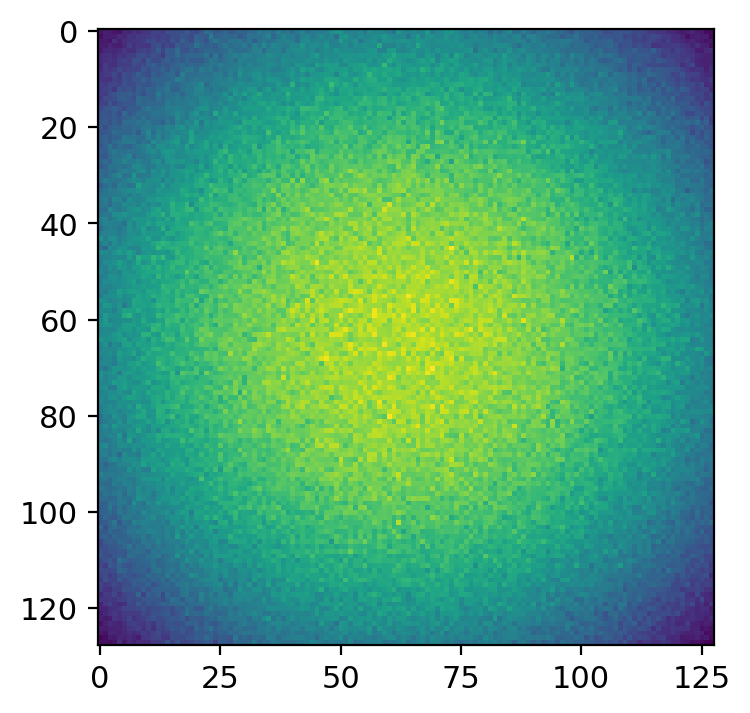

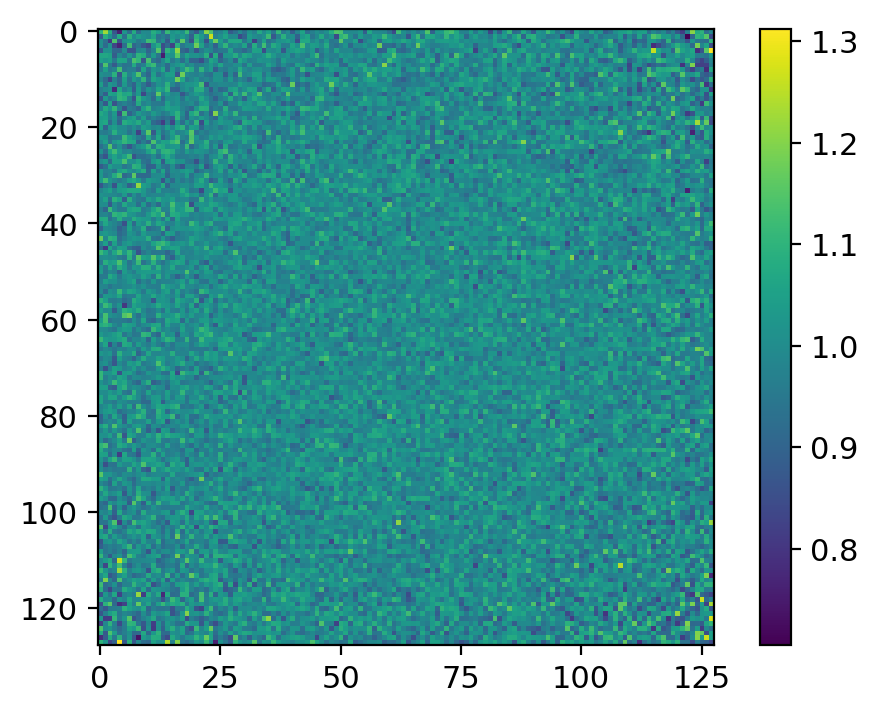

In [8]:
"""Fit with BaSiC"""
basic.fit(synthetic_images)
plt.imshow(basic.flatfield)
plt.show()
plt.imshow(basic.flatfield/truth) ; plt.colorbar() ; plt.show()

# Exporting data for test

(147, 128, 128) uint16


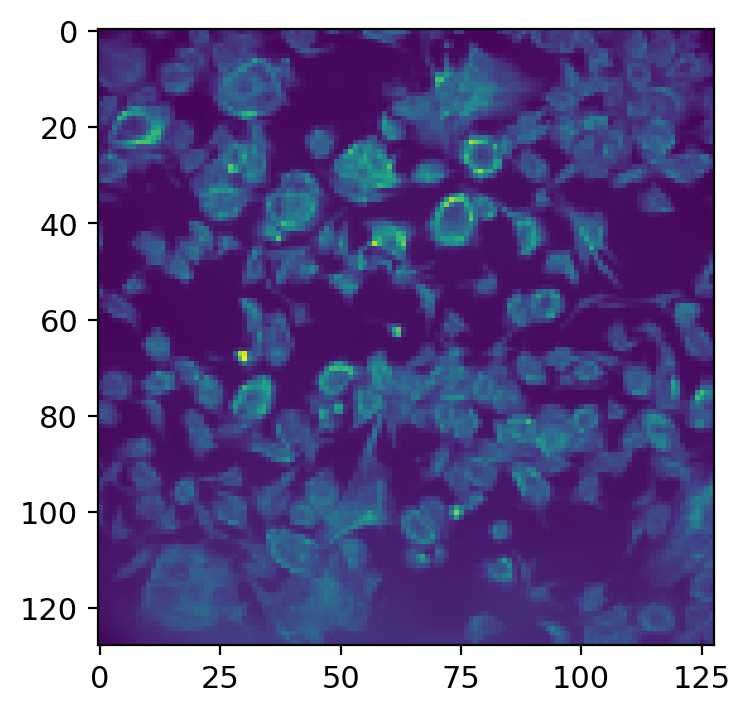

(100, 128, 171) uint8


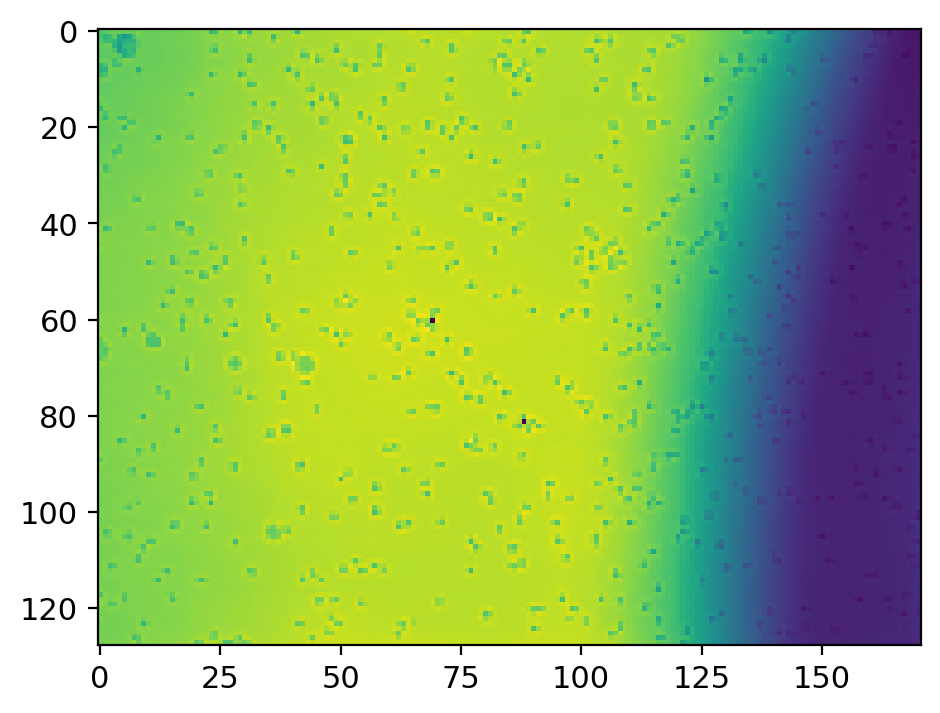

(189, 128, 171) uint8


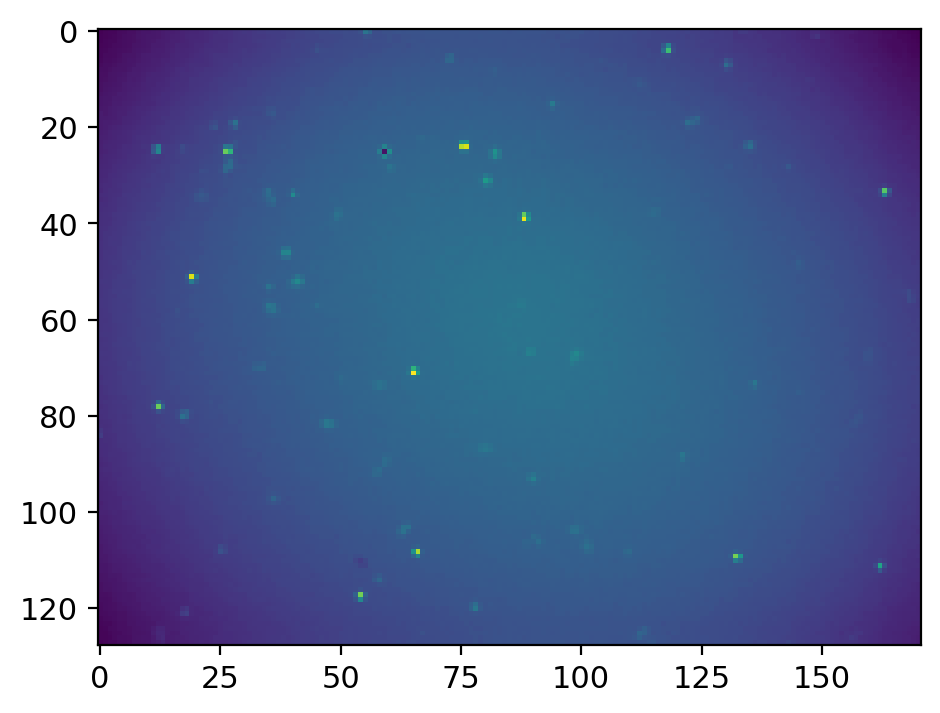

(200, 128, 171) uint8


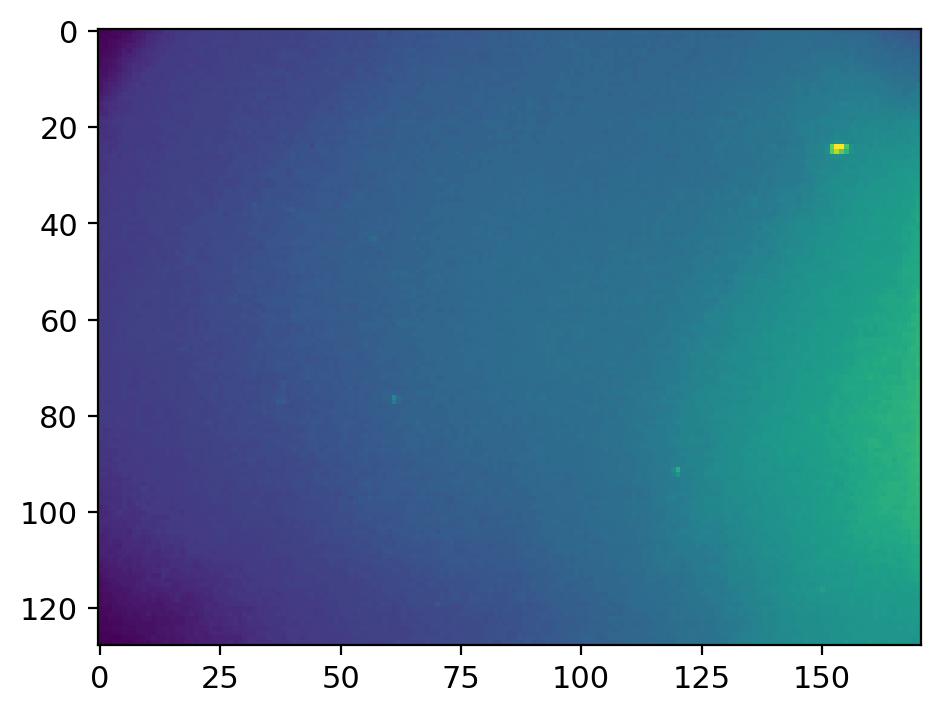

(63, 128, 128) uint16


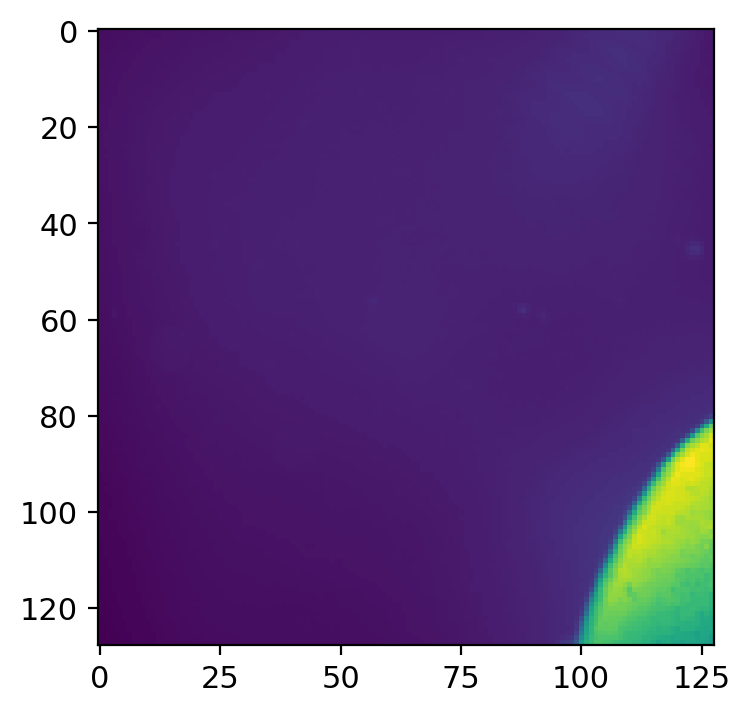

In [10]:
images = {}
keys = ["cell_culture","timelapse_brightfield","timelapse_nanog","timelapse_pu1","wsi_brain"]
for k in keys:
    d=np.load(f"../data/{k}.npz")
    im=d["images"]
    print(im.shape, im.dtype)
    plt.imshow(im[10])
    images[k]=im
    plt.show()

In [15]:
os.makedirs("../tests/data/fit", exist_ok=True)

for k,im in images.items():
    for fitting_mode, get_darkfield, sort_intensity in \
        product(["ladmap","approximate"],[True,False],[True,False]):
        b = BaSiC(fitting_mode=fitting_mode, 
#                  lambda_flatfield_coef=1.0 / 400 * 0.5 if fitting_mode=="approximate" else 0.1,
#                  lambda_darkfield_coef=0.2 if fitting_mode=="approximate" else 0.2,
                  max_reweight_iteration=1,
                  get_darkfield=get_darkfield, 
                  sort_intensity=sort_intensity)
        b.fit(im)
        plt.figure(figsize=(9,3))
        plt.subplot(131)
        plt.imshow(b.flatfield)
        plt.colorbar()
        plt.subplot(132)
        plt.imshow(b.darkfield)
        plt.colorbar()
        plt.subplot(133)
        plt.plot(b.baseline)
        boolstr = lambda x:"with" if x else "without"
        k2=f"{k}_{fitting_mode}_{boolstr(get_darkfield)}-darkfield_{boolstr(sort_intensity)}-sort"
        plt.suptitle(k2)
        plt.tight_layout()
        plt.savefig(f"../tests/data/fit/plots/{k2}.png")
        plt.show()
        np.savez_compressed(f"../tests/data/fit/{k2}.npz",
            image_name=k,
            flatfield=b.flatfield,
            darkfield=b.darkfield,
            baseline=b.baseline,
            params=b.dict()
        )
        break
    break

INFO:basicpy.basicpy:Initializing BaSiC 5479335872 with parameters: 
fitting_mode: ladmap
max_reweight_iteration: 1
get_darkfield: True
sort_intensity: True

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 6.176957754178147e-07.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 4.350797837560094e-07.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.6686723828315735
INFO:basicpy.basicpy:elapsed time: 19.329251104999912 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 1.9440408038917667e-07.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score: 2.254725456237793
INFO:basicpy.basicpy:elapsed time: 42.32962857099983 seconds
INFO:basicpy.basicpy:reweighting iteration 3


KeyboardInterrupt: 

In [13]:

np.mean(b._S)

DeviceArray(0.13924667, dtype=float32)

In [14]:
b._S

DeviceArray([[-10.617079 , -10.366263 , -10.0794325, ...,  -6.6635027,
               -7.1851335,  -8.141939 ],
             [-10.185935 ,  -9.936554 ,  -9.374392 , ...,  -6.1770177,
               -6.897827 ,  -7.6160207],
             [ -9.596344 ,  -9.126541 ,  -8.551209 , ...,  -6.310834 ,
               -6.444807 ,  -7.2527943],
             ...,
             [ -9.875346 ,  -9.257477 ,  -9.037387 , ...,  -6.333854 ,
               -5.370241 ,  -5.7224836],
             [-10.42215  ,  -9.775369 ,  -9.372182 , ...,  -5.83842  ,
               -5.7815123,  -6.5097694],
             [-10.903194 , -10.4913645,  -9.7728405, ...,  -6.0495086,
               -6.3024664,  -7.048067 ]], dtype=float32)